In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin as pg
import sklearn
import math
%matplotlib inline

In [2]:
dataf= sns.load_dataset('titanic')
dataf

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,2,male,27.0,0,0,13.0000,S,Second,man,True,NaN,Southampton,no,True
887,1,1,female,19.0,0,0,30.0000,S,First,woman,False,B,Southampton,yes,True
888,0,3,female,NaN,1,2,23.4500,S,Third,woman,False,NaN,Southampton,no,False
889,1,1,male,26.0,0,0,30.0000,C,First,man,True,C,Cherbourg,yes,True


In [3]:
dataf.isnull().sum()

survived         0
pclass           0
sex              0
age            177
sibsp            0
parch            0
fare             0
embarked         2
class            0
who              0
adult_male       0
deck           688
embark_town      2
alive            0
alone            0
dtype: int64

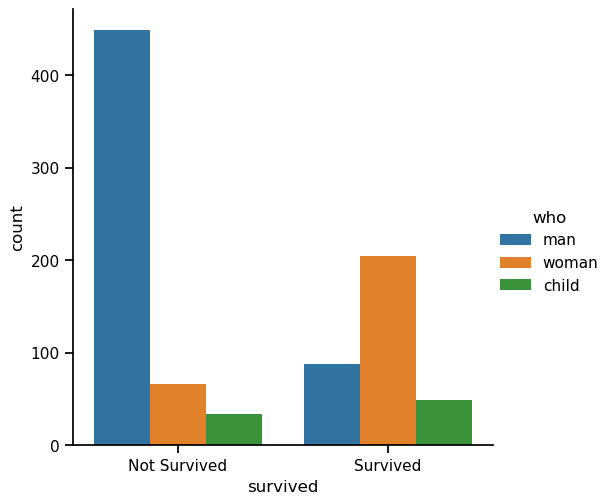

In [4]:
sns.set_context('notebook')
plt.rcParams["figure.dpi"] = 100
sns.catplot(data= dataf, x= 'survived', kind= 'count', hue= 'who')
plt.xticks(ticks= [0, 1], labels= ['Not Survived', 'Survived'])
plt.show();

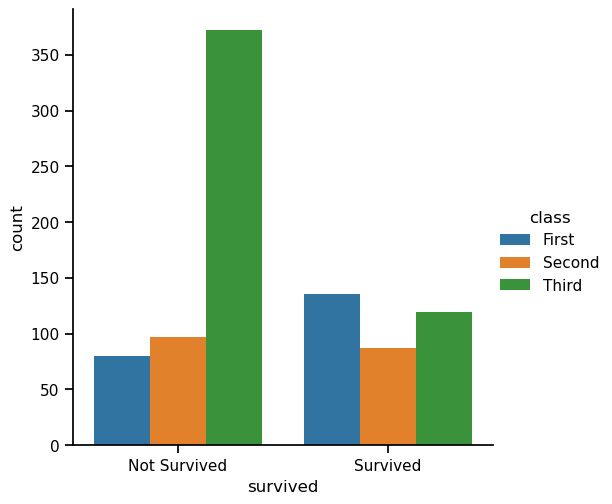

In [5]:
sns.catplot(data= dataf, x= 'survived', kind= 'count', hue= 'class')
plt.xticks(ticks= [0, 1], labels= ['Not Survived', 'Survived'])
plt.show();

In [6]:
# is there a substanial relation between class and gender on age of passenger? 
# for this we have 2 IV's which are ordinal in nature. A 2-way Anova is best for such a purpose. 

age_data= dataf['age'].dropna(how= 'any')

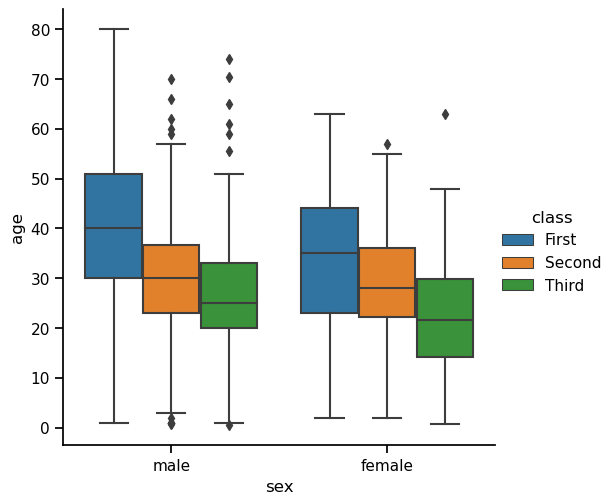

In [7]:
sns.catplot(data= dataf, x= 'sex', y= 'age', hue= 'class', kind= 'box')
plt.show();

In [8]:
pg.anova(data= dataf, dv= 'age', between= ['sex', 'class'], detailed=True)
# for an Alpha= 0.05,  the interaction between the sex and class is not significant

,Source,SS,DF,MS,F,p-unc,np2
0,sex,3389.132827,1.0,3389.132827,19.095829,1.429337e-05,0.026263
1,class,23010.355131,2.0,11505.177566,64.825107,1.404675e-26,0.154778
2,sex * class,481.844296,2.0,240.922148,1.357459,2.579827e-01,0.003820
3,Residual,125656.031067,708.0,177.480270,NaN,NaN,NaN


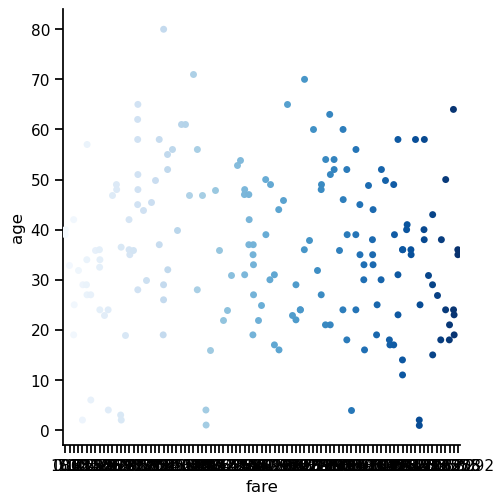

In [9]:
# simple regression model between age and fare. 
sns.catplot(data= dataf.dropna(how= 'any'), x= 'fare', y= 'age', palette= 'Blues')
plt.show();

In [10]:
dataf.dropna(how= 'any', inplace= True)
des_mat= np.vstack((np.ones(len(dataf['fare'])), dataf['fare'])).T
beta= np.linalg.lstsq(des_mat, dataf['age'], rcond= None)[0]
ycap= np.dot(des_mat, beta)

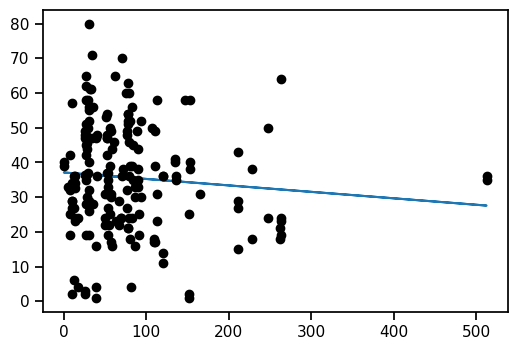

In [11]:
plt.plot(dataf['fare'], ycap)
plt.plot(dataf['fare'], dataf['age'], 'ko')
plt.show();

In [12]:
ssr= 0
sst= 0
agedata= list(dataf['age'])
faredata= list
from sklearn.metrics import r2_score
for x in range(len(dataf['age'])):
    ssr+= math.pow((agedata[x]- ycap[x]), 2)
    sst+= math.pow((agedata[x]- np.mean(dataf['age'])), 2)

r2_val= (1- (ssr/sst))
print(r2_val)
print(sklearn.metrics.r2_score(agedata, ycap))



0.008231998940857133
0.008231998940857022


In [13]:
data1= dataf['fare'].loc[dataf['age']< 36]
data2= dataf['fare'].loc[dataf['age']> 36]

print(stats.mannwhitneyu(data1, data2))
print(stats.ttest_ind(data1, data2, alternative= 'greater'))


MannwhitneyuResult(statistic=3849.0, pvalue=0.528940140673613)
Ttest_indResult(statistic=1.4751805526788826, pvalue=0.07101229363489553)


In [14]:
# permutation testing the t-val

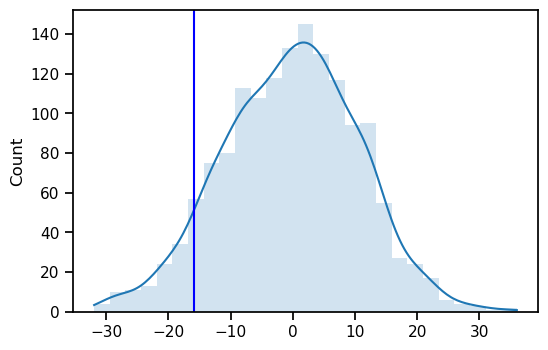

0.07487181229997897


In [15]:
all_data= np.hstack((data1, data2))
conds= np.hstack((np.ones(len(data1)), 2*np.ones(len(data2))))
nperms= 1500
ndiffs= np.zeros(nperms)
for x in range(nperms):
    fconds= np.random.permutation(len(data1)+ len(data2))
    fconds[fconds<len(data1)]= 1
    fconds[fconds>1]= 2
    nmeandiff= np.mean(all_data[fconds== 2])- np.mean(all_data[fconds==1])
    ndiffs[x]= nmeandiff

obsval= np.mean(data2)- np.mean(data1)

sns.histplot(ndiffs, kde= True, alpha= 0.2, linewidth= 0)
plt.axvline(obsval, color= 'b')
plt.show();

z_val= (obsval- np.mean(ndiffs))/ np.std(ndiffs)

print(1- stats.norm.cdf(abs(z_val)))

In [16]:
print(np.mean(data2), np.mean(data1))

68.86244938271605 84.76717666666669


In [17]:
pg.anova(data= dataf, dv= 'fare', between= ['class', 'sex'], detailed= True)

,Source,SS,DF,MS,F,p-unc,np2
0,class,122815.948272,2.0,61407.974136,11.826919,0.000015,0.118474
1,sex,23156.812263,1.0,23156.812263,4.459905,0.036111,0.024714
2,class * sex,5038.976885,2.0,2519.488442,0.485243,0.616369,0.005484
3,Residual,913830.842516,176.0,5192.220696,NaN,NaN,NaN


MannwhitneyuResult(statistic=3091.5, pvalue=0.003284782702011032)


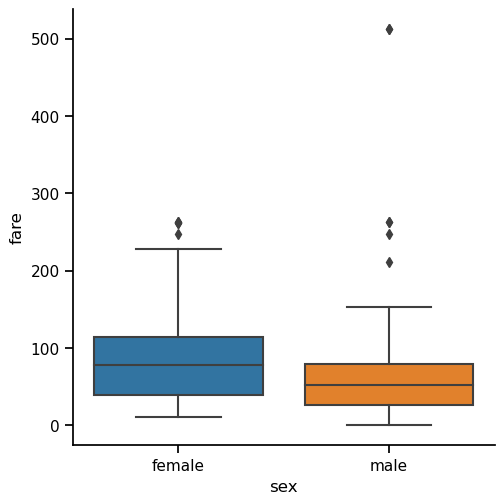

In [18]:
data1= dataf['fare'].loc[dataf['sex']== 'male']
data2= dataf['fare'].loc[dataf['sex']== 'female']
print(stats.mannwhitneyu(data1, data2))
sns.catplot(data= dataf, x= 'sex', y='fare', kind= 'box')
plt.show();


In [19]:
# through logistic regression find the effect of age and gender on survivability
from sklearn.linear_model import LogisticRegression
dataf.dropna(how= 'any', inplace=True)
age_data= list(dataf['age'])
male= list(dataf['adult_male'])

logmodel= LogisticRegression(solver= 'liblinear')
desmat= np.vstack((age_data, male)).T

logmodel.fit(desmat, np.array(dataf['survived']))
print(logmodel.coef_)
print(logmodel.intercept_)



[[-0.00462598 -2.36093663]]
[2.21983344]


In [20]:
pred= logmodel.predict(desmat)
predA= logmodel.predict_proba(desmat)
print(pred)
print(dataf['survived'])
print(predA)
print(logmodel.score(desmat, np.array(dataf['survived'])))

[1 1 0 1 1 0 0 0 1 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 0 1 1 1 1 1 1 0 1
 1 0 1 0 0 1 0 1 0 0 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 1 1 1 1 1 1
 1 0 0 0 1 1 1 0 0 0 1 0 1 0 0 0 0 0 0 1 0 1 0 0 1 1 1 0 0 0 1 1 1 0 1 1 0
 0 1 1 1 0 1 1 0 1 0 1 0 1 1 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 0 0
 1 1 0 1 0 0 1 0 0 1 1 1 1 1 1 1 0 0 1 1 0 1 1 1 1 1 0 1 0 1 0 1 1 0]
1      1
3      1
6      0
10     1
11     1
      ..
871    1
872    0
879    1
887    1
889    1
Name: survived, Length: 182, dtype: int64
[[0.11465537 0.88534463]
 [0.11325414 0.88674586]
 [0.59650082 0.40349918]
 [0.09963116 0.90036884]
 [0.124387   0.875613  ]
 [0.57404805 0.42595195]
 [0.56724772 0.43275228]
 [0.55700034 0.44299966]
 [0.11992291 0.88007709]
 [0.60868594 0.39131406]
 [0.58644111 0.41355889]
 [0.11049646 0.88950354]
 [0.56383787 0.43616213]
 [0.10779777 0.89220223]
 [0.58756259 0.41243741]
 [0.61527673 0.38472327]
 [0.56156126 0.43843874]
 [0.55928205 0.44071795]
 [0.58868316 0.41131684]
 [0.56269989 0

In [21]:
from sklearn.model_selection import train_test_split
X_train, x_test, Y_train, y_test= train_test_split(dataf.drop('survived', axis= 1), dataf['survived'], test_size= 0.5)
y_test

319    1
332    0
370    1
492    0
724    1
      ..
699    0
452    0
27     0
297    0
62     0
Name: survived, Length: 91, dtype: int64

In [22]:
sns.get_dataset_names()

['anagrams',
 'anscombe',
 'attention',
 'brain_networks',
 'car_crashes',
 'diamonds',
 'dots',
 'exercise',
 'flights',
 'fmri',
 'gammas',
 'geyser',
 'iris',
 'mpg',
 'penguins',
 'planets',
 'taxis',
 'tips',
 'titanic']

In [23]:
df= sns.load_dataset('mpg')
df

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790,15.6,82,usa,ford mustang gl
394,44.0,4,97.0,52.0,2130,24.6,82,europe,vw pickup
395,32.0,4,135.0,84.0,2295,11.6,82,usa,dodge rampage
396,28.0,4,120.0,79.0,2625,18.6,82,usa,ford ranger


In [24]:
df.isnull().any()
df.dropna(how= 'any', inplace=True)

In [25]:
data1= pd.get_dummies(df['origin'])
usdata= data1['usa']
df['us_notus']= usdata
feature= df.iloc[:, 2:-3]
imp_cols= list(df.columns)[2:-4]

for x in imp_cols:
    dataus= df[x].loc[df['us_notus']== 1]
    datanotus= df[x].loc[df['us_notus']!= 1]
    t_stat, p= stats.mannwhitneyu(dataus, datanotus)
    print(pg.anova(data= df, dv= x, between= 'us_notus'))
    print(p)

df.iloc[:, 2:-4].corr()


     Source  ddof1  ddof2           F         p-unc       np2
0  us_notus      1    390  294.512772  1.399613e-49  0.430252
1.7080670235382735e-45
     Source  ddof1  ddof2           F         p-unc       np2
0  us_notus      1    390  122.977295  5.026676e-25  0.239732
9.508818147459048e-25
     Source  ddof1  ddof2          F         p-unc       np2
0  us_notus      1    390  220.49572  7.495824e-40  0.361175
2.422206114428279e-35
     Source  ddof1  ddof2          F         p-unc      np2
0  us_notus      1    390  27.862978  2.166688e-07  0.06668
2.9223459748852948e-06


,displacement,horsepower,weight,acceleration
displacement,1.000000,0.897257,0.932994,-0.543800
horsepower,0.897257,1.000000,0.864538,-0.689196
weight,0.932994,0.864538,1.000000,-0.416839
acceleration,-0.543800,-0.689196,-0.416839,1.000000


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
model= LogisticRegression(solver= 'liblinear')

X_train, x_test, Y_train, y_test= train_test_split(df.iloc[:, 2:-4], df['us_notus'], test_size= 0.3, random_state= 0)
model.fit(X_train, Y_train)
prob= model.predict(x_test)
print(prob)
print(model.score(X_train, Y_train))
print(confusion_matrix(y_true= y_test, y_pred= prob))
print(classification_report(y_test, prob))


[0 0 1 1 0 1 0 1 1 0 1 1 1 1 1 0 0 1 0 1 1 1 1 1 0 1 1 1 1 1 0 0 0 0 1 0 0
 1 1 1 1 0 0 1 0 1 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 1 0 1 1 0 0 0 1 0 1 1
 1 1 0 1 0 0 1 0 1 0 1 1 0 0 0 0 1 1 0 1 1 0 0 0 0 0 1 0 0 1 0 1 0 1 0 1 1
 0 0 1 1 0 1 1]
0.8576642335766423
[[42  5]
 [ 8 63]]
              precision    recall  f1-score   support

           0       0.84      0.89      0.87        47
           1       0.93      0.89      0.91        71

    accuracy                           0.89       118
   macro avg       0.88      0.89      0.89       118
weighted avg       0.89      0.89      0.89       118



In [27]:
# the above can be defined a full model. a model that only records acceleration and displacement can be defined as nested under 
# model above

# model in which we only use acceleration and displacement for logistic regression

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
data_fin= df[['displacement', 'acceleration']]
print(data_fin)
logistic_model= LogisticRegression(solver= 'liblinear')
X_train, x_test, Y_train, y_test= train_test_split(data_fin, df['us_notus'], test_size= 0.3)
logistic_model.fit(X_train, Y_train)
pred= logistic_model.predict(x_test)
print(logistic_model.score(x_test, y_test))
print(confusion_matrix(y_test, pred))



     displacement  acceleration
0           307.0          12.0
1           350.0          11.5
2           318.0          11.0
3           304.0          12.0
4           302.0          10.5
..            ...           ...
393         140.0          15.6
394          97.0          24.6
395         135.0          11.6
396         120.0          18.6
397         119.0          19.4

[392 rows x 2 columns]
0.847457627118644
[[40  9]
 [ 9 60]]


In [28]:
df1= sns.load_dataset('iris')
df1

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

logmodel= LogisticRegression(solver= 'newton-cg')
data_d= pd.get_dummies(df1['species'])
df1['setosa']= data_d['setosa']

data1= df1.iloc[:, 0:-2]

X_train, x_test, Y_train, y_test= train_test_split(data1, data_d['setosa'], test_size= 0.2)
logmodel.fit(X_train, Y_train)
pred= logmodel.predict(x_test)
print(logmodel.score(x_test, y_test))
print(logmodel.predict_proba(x_test))
print(confusion_matrix(y_test, pred))
print(classification_report(y_test, pred))
print(pred)
print(list(y_test))

1.0
[[9.80247053e-01 1.97529471e-02]
 [9.91429896e-01 8.57010417e-03]
 [9.98881663e-01 1.11833721e-03]
 [1.22551607e-02 9.87744839e-01]
 [9.86413238e-01 1.35867623e-02]
 [2.04590740e-02 9.79540926e-01]
 [2.36325937e-02 9.76367406e-01]
 [9.95078588e-01 4.92141181e-03]
 [1.98147756e-02 9.80185224e-01]
 [2.13427486e-02 9.78657251e-01]
 [9.97403455e-01 2.59654474e-03]
 [9.99469487e-01 5.30512590e-04]
 [9.99288001e-01 7.11999168e-04]
 [9.80256510e-01 1.97434900e-02]
 [9.99451797e-01 5.48202624e-04]
 [9.99559175e-01 4.40825399e-04]
 [9.99982180e-01 1.78200577e-05]
 [1.57584253e-02 9.84241575e-01]
 [1.69681516e-02 9.83031848e-01]
 [9.98610807e-01 1.38919291e-03]
 [9.99385264e-01 6.14735731e-04]
 [9.99824413e-01 1.75586548e-04]
 [9.99894819e-01 1.05181172e-04]
 [9.54168158e-01 4.58318418e-02]
 [9.71651027e-01 2.83489730e-02]
 [9.90213411e-01 9.78658892e-03]
 [9.99975425e-01 2.45749204e-05]
 [1.69270986e-02 9.83072901e-01]
 [9.95833308e-01 4.16669161e-03]
 [4.17403067e-02 9.58259693e-01]]
[[21 

In [30]:
df1= pd.read_csv('auto-mpg.csv')
df1

,mpg,cylinders,displacement,horsepower,weight,acceleration,model year,origin,car name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino
...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86,2790,15.6,82,1,ford mustang gl
394,44.0,4,97.0,52,2130,24.6,82,2,vw pickup
395,32.0,4,135.0,84,2295,11.6,82,1,dodge rampage
396,28.0,4,120.0,79,2625,18.6,82,1,ford ranger


In [31]:
df_imp= df.iloc[:, 0:6]
np.max(df_imp['weight'])

5140

In [32]:
df_imp.corr()

,mpg,cylinders,displacement,horsepower,weight,acceleration
mpg,1.000000,-0.777618,-0.805127,-0.778427,-0.832244,0.423329
cylinders,-0.777618,1.000000,0.950823,0.842983,0.897527,-0.504683
displacement,-0.805127,0.950823,1.000000,0.897257,0.932994,-0.543800
horsepower,-0.778427,0.842983,0.897257,1.000000,0.864538,-0.689196
weight,-0.832244,0.897527,0.932994,0.864538,1.000000,-0.416839
acceleration,0.423329,-0.504683,-0.543800,-0.689196,-0.416839,1.000000


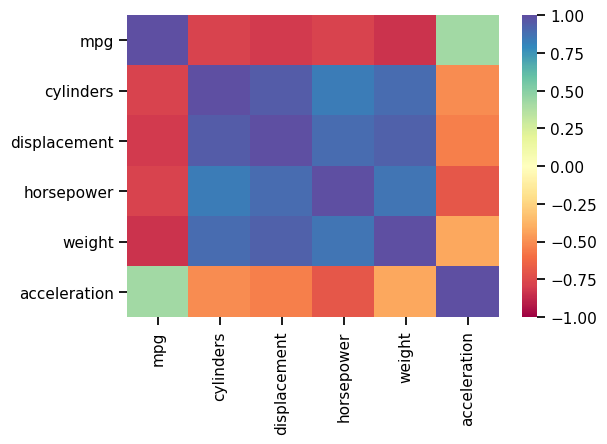

In [33]:
sns.heatmap(df_imp.corr(), cmap= 'Spectral', vmin= -1, vmax=1)
plt.show();

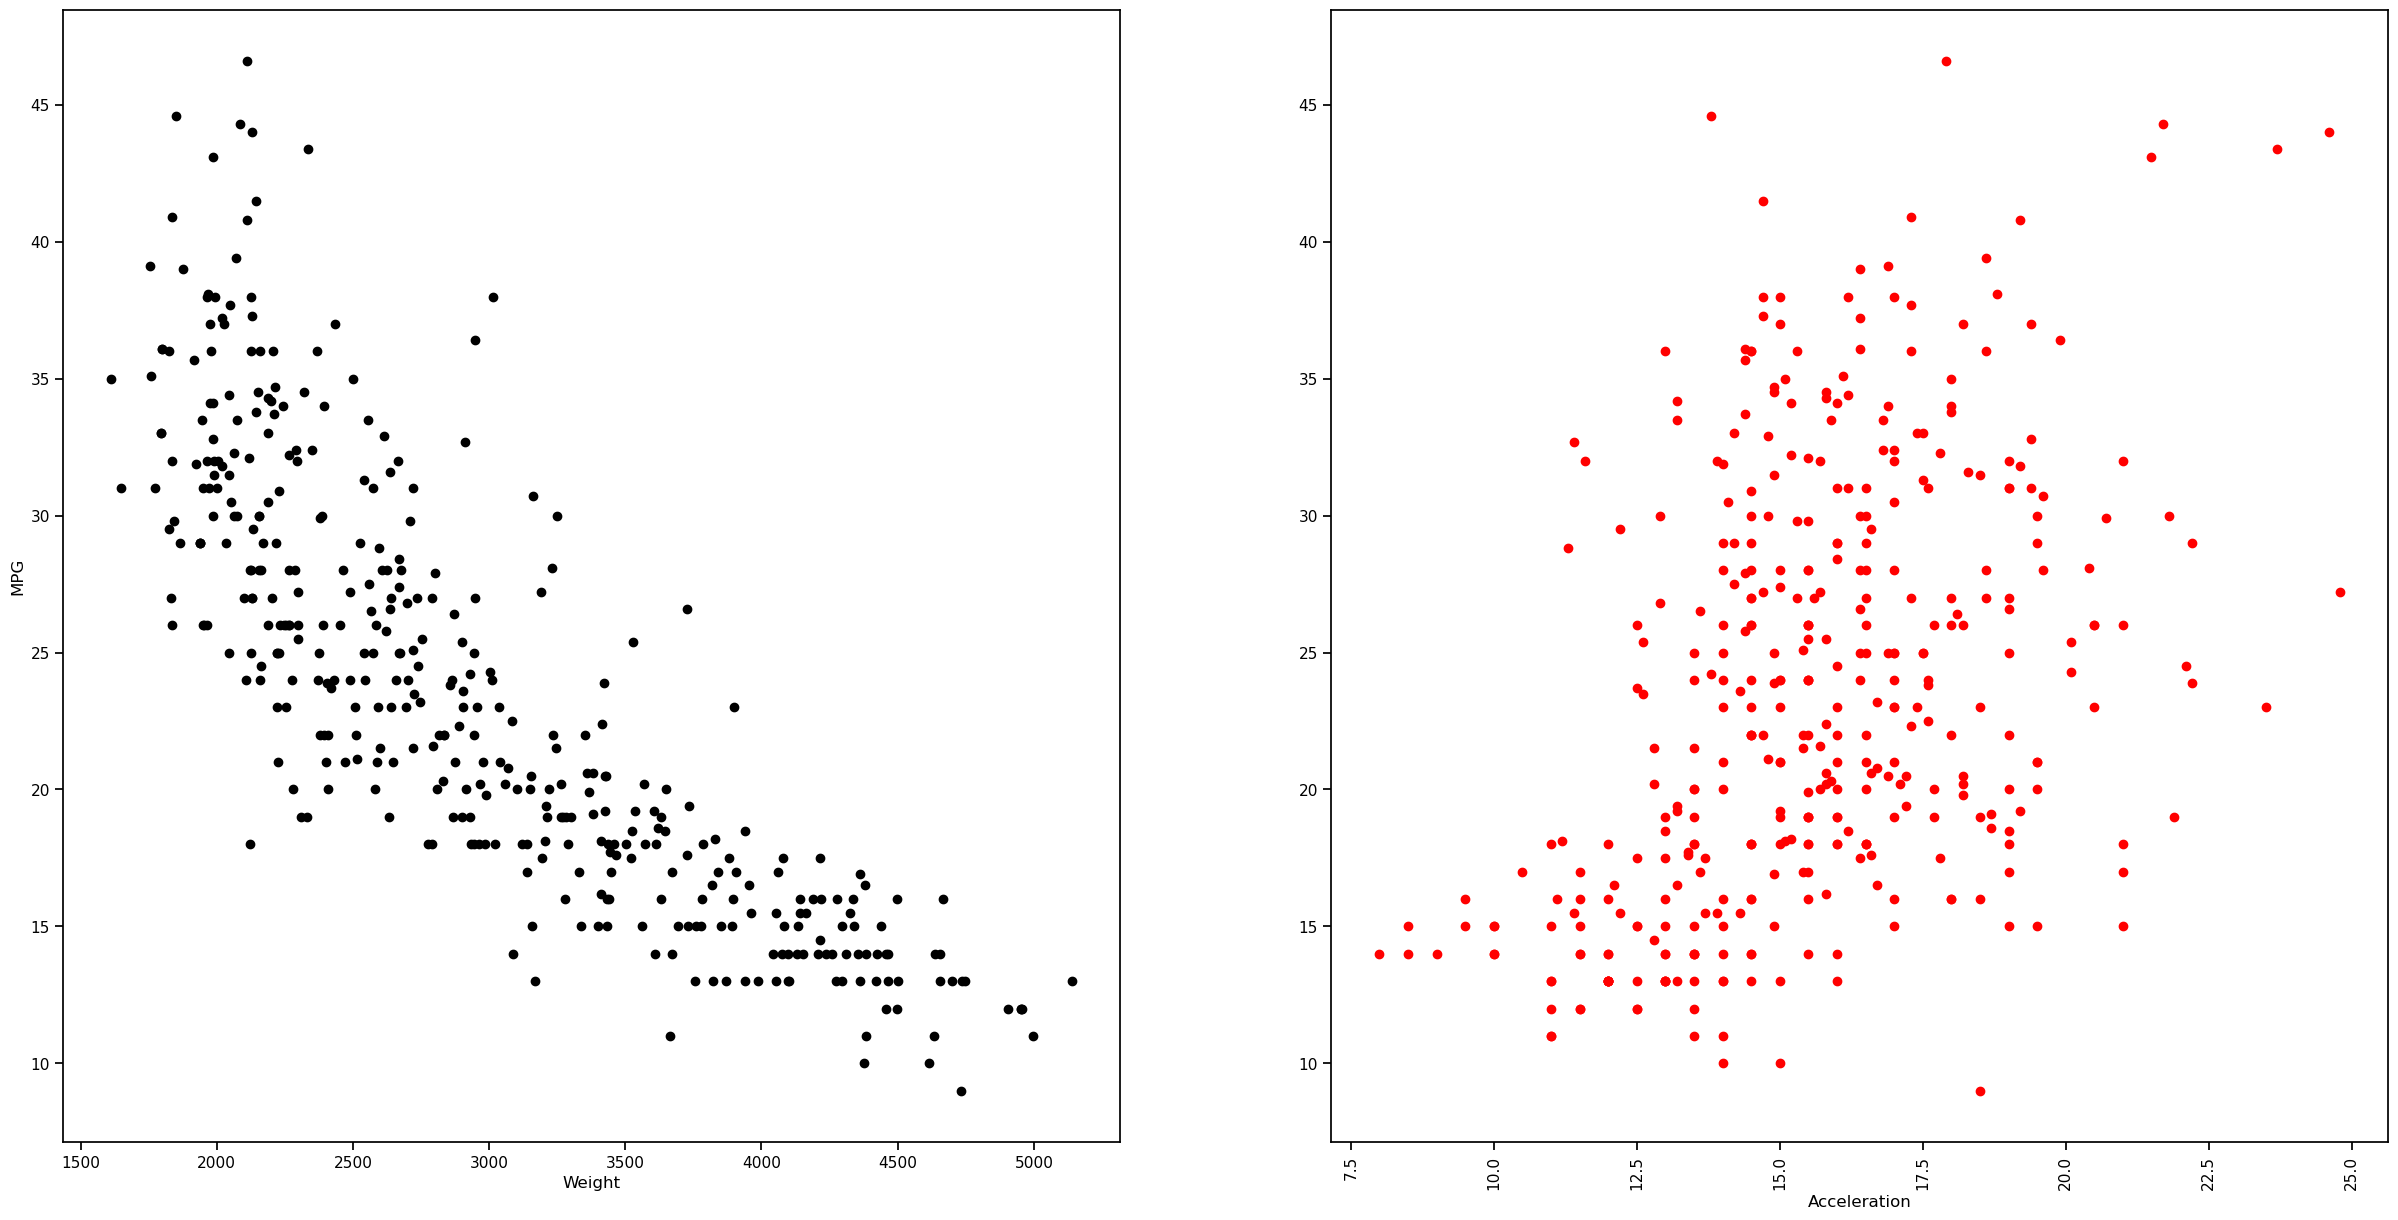

In [34]:
#acceleration and weight are two qualities that are differently related. we may be able to get rid of multicollinearity
fig, ax= plt.subplots(1, 2, figsize= (30,15))
plt.xticks(rotation= 90)
plt.rcParams['axes.labelpad']= 10
ax[0].plot(df1['weight'], df1['mpg'], 'ko')
ax[0].set_xlabel('Weight')
ax[0].set_ylabel('MPG')
ax[1].plot(df1['acceleration'], df1['mpg'], 'ro')
ax[1].set_xlabel('Acceleration')
plt.show();

In [36]:
dweight= np.array(df1['weight'])
daccln= np.array(df1['acceleration'])
des_mat= np.vstack((np.ones(len(dweight)), dweight, daccln, dweight**2, daccln**2 , dweight*daccln)).T
beta= np.linalg.lstsq(des_mat, df1['mpg'], rcond= None)[0]
vals= np.dot(des_mat, beta)
mean= np.mean(df1['mpg'])


In [37]:
from sklearn import metrics
print(metrics.r2_score(vals, df1['mpg']))

0.6254862989464078


In [38]:
from statsmodels import regression
des_mat1= np.vstack((np.ones(len(df1['mpg'])), df1['weight'], df1['acceleration'])).T
regression.linear_model.OLS(endog= df1['mpg'], exog= des_mat1).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.697
Method:                 Least Squares   F-statistic:                     457.0
Date:                Wed, 19 Jan 2022   Prob (F-statistic):          1.69e-103
Time:                        17:58:17   Log-Likelihood:                -1144.2
No. Observations:                 398   AIC:                             2294.
Df Residuals:                     395   BIC:                             2306.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.3998      1.865     22.201      0.000      37.734      45.066
x1            -0.0073      0.000    -26.131      0.000      -0.008      -0.007
x2             0.2508      0.086      2.909      0.004       0.081       0.420
==============================================================================
Omnibus:                       30.694   Durbin-Watson:                   0.804
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               38.296
Skew:                           0.625   Prob(JB):                     4.83e-09
Kurtosis:                       3.864   Cond. No.                     2.67e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.67e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [39]:
df1= pd.read_csv('rest_data.csv')
df1

,name,rating,location,cuisine_makeup,cost_for_one
0,Nando's,4.1,"Opp Rajiv Chowk Metro Station, Connaught Place","Fast Food, Portuguese, African, Grill, Salads",225.0
1,Biryani Blues,4.2,"Scindia House, Connaught Place","Biryani, Hyderabadi, Lucknowi, Kebabs, Dessert...",200.0
2,Saravana Bhavan,4.4,"Janpath Market, Connaught Place",South Indian,275.0
3,Maalgaadi by Dhaba Estd 1986 Delhi,4.2,"Connaught Place, Connaught Place","North Indian, Indian, Biryani, Punjabi, Kebabs...",150.0
4,Burger King,4.3,"Inner Circle, Connaught Place","American, Fast Food",175.0
...,...,...,...,...,...
925,Meals and Bowls,4.1,"GTB, Mukherjee Nagar","North Indian, Punjabi, Home Food, Mughlai",100.0
926,Indian Kathi Company,3.8,"GTB, Mukherjee Nagar","North Indian, Snacks, Fast Food",100.0
927,Subclub,3.3,"GTB, Mukherjee Nagar","Salads, Continental, American",100.0
928,Pikwik Since 1991,4,"GTB, Mukherjee Nagar","North Indian, Chinese, Biryani, Desserts, Pan-...",150.0
